# Q Function
* used to approximate the reward based on a state
* Q(s,a) calculates the expected future value from state **s** and action **a**
* in DQN, we use a **neural network to approximate the reward**

# Classes
* Environment
* Agent
* Runner

## Environment

In [1]:
class Action:
    def __init__(self, act, days, percentage):
        self.act = act
        self.days = days
        self.percentage = percentage

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

BUY = 'buy'
SELL = 'sell'
SKIP = 'skip'

class Environment:
    
    min_days_to_hold = 5
    max_days_to_hold = 15
    max_drawdowns = 3
    
    def __init__(self, 
                 ticker, 
                 initial_deposit = 100000,
                 from_date = datetime.datetime(2007, 1, 1), 
                 to_date = datetime.datetime(2017, 1, 1),
                 window = 50):
        self.initial_deposit = initial_deposit
        self.window = window
        self.data = pdr.get_data_google(ticker, from_date, to_date)
        self.pct_data = self.data.pct_change().fillna(0)
        self.data_length = len(self.data)
        
        actions = np.array([BUY, SELL, SKIP])
        days_to_holds = np.arange(Environment.min_days_to_hold, 
                                  Environment.max_days_to_hold + 1,
                                  2)
        
        self.action_space = [Action(act, days, 3) for act in actions for days in days_to_holds]
        self.reset()
        
    def reset(self):
        self.deposit = self.initial_deposit
        self.current_index = self.window
        self.actions = {}
        self.drawdowns = 0
        
        return self.state()
    
    def score(self):
        return self.deposit
    
    def enough_data_provided(self):
        return self.current_index + Environment.max_days_to_hold <= self.data_length
    
    def state(self):
        return self.pct_data.iloc[self.current_index - self.window:self.current_index]['Close']
    
    # def price_state(self):
    #    return self.data.iloc[self.current_index - self.window:self.current_index]['Close']
        
    def state_size(self):
        return self.window
    
    def action_size(self):
        return len(self.action_space)
        
    def step(self, action_idx: int):
        action = self.action_space[action_idx]
        #print('\t=> current action is: {} at {}'.format(action, self.data.index[self.current_index]))
        
        df = self.data.iloc[self.current_index: self.current_index + action.days]
        on_date = df.index[0]
        first_day_price = df.iloc[0]['Close']
        last_day_price = df.iloc[-1]['Close']
        
        if action.act == BUY:
            reward = last_day_price - first_day_price
        elif action.act == SELL:
            reward = first_day_price - last_day_price
        elif action.act == SKIP:
            reward = 0
            
        self.actions[on_date] = (action, reward)
        
        self.current_index += action.days
        self.deposit += reward * (self.deposit*action.percentage/100)
        
        if reward < 0:
            self.drawdowns += 1
        else:
            self.drawdowns = 0
        
        next_state = self.state()
        done = self.drawdowns > Environment.max_drawdowns
        _ = None
        return next_state, reward, done, _ 

## Agent

In [3]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dense(36, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Using TensorFlow backend.


## Runner

In [4]:
env = Environment('AAPL')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 18, state size: 50


In [5]:
agent = Agent(state_size, action_size)
EPISODES = 50
batch_size = 32

In [6]:
max_reward = None
for e in range(EPISODES):
    print('==> EPISODE {}'.format(e))
    state = env.reset()
    state = state.values.reshape([1, state_size])
    while env.enough_data_provided():
        action_idx = agent.act(state)
        next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
        # reward = reward if not done else -10
        next_state = next_state.values.reshape([1, state_size])
        agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
        
        if done:
            break
        elif len(agent.memory) > batch_size:
            agent.replay(batch_size)
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, env.score(), agent.epsilon))
    
    if max_reward is None or max_reward[0] < env.score():
        max_reward = (env.score(), env.actions)

==> EPISODE 0
episode: 0/50, score: 80752.80900624598, e: 1.0
episode: 0/50, score: 79808.0011408729, e: 1.0
episode: 0/50, score: 85697.83162506933, e: 0.99
episode: 0/50, score: 77033.78084777482, e: 0.99
episode: 0/50, score: 83920.60085556588, e: 0.99
episode: 0/50, score: 92153.21179949689, e: 0.99
episode: 0/50, score: 105920.90164234172, e: 0.99
episode: 0/50, score: 105793.7965603709, e: 0.98
episode: 0/50, score: 99858.76457333409, e: 0.98
episode: 0/50, score: 105341.01074841013, e: 0.98
episode: 0/50, score: 108058.80882571911, e: 0.98
episode: 0/50, score: 108058.80882571911, e: 0.98
episode: 0/50, score: 112078.59651403586, e: 0.97
episode: 0/50, score: 110935.3948295927, e: 0.97
episode: 0/50, score: 112133.4970937523, e: 0.97
episode: 0/50, score: 111258.85581642103, e: 0.97
episode: 0/50, score: 114296.22258020932, e: 0.97
episode: 0/50, score: 111450.2466379621, e: 0.96
episode: 0/50, score: 111450.2466379621, e: 0.96
episode: 0/50, score: 109410.7071244874, e: 0.96
ep

episode: 2/50, score: 79057.10769426293, e: 0.71
episode: 2/50, score: 79602.60173735334, e: 0.71
episode: 2/50, score: 80581.71373872278, e: 0.71
episode: 2/50, score: 75650.11285791296, e: 0.71
episode: 2/50, score: 74311.1058603279, e: 0.7
episode: 2/50, score: 70075.3728262892, e: 0.7
episode: 2/50, score: 70075.3728262892, e: 0.7
episode: 2/50, score: 70075.3728262892, e: 0.7
episode: 2/50, score: 70495.82506324693, e: 0.7
episode: 2/50, score: 67598.44665314749, e: 0.7
episode: 2/50, score: 68774.65962491227, e: 0.7
episode: 2/50, score: 68774.65962491227, e: 0.69
episode: 2/50, score: 68774.65962491227, e: 0.69
episode: 2/50, score: 72488.49124465753, e: 0.69
episode: 2/50, score: 66312.4717906127, e: 0.69
episode: 2/50, score: 70529.94499649567, e: 0.69
episode: 2/50, score: 83775.46866683757, e: 0.69
episode: 2/50, score: 85132.63125924034, e: 0.69
episode: 2/50, score: 84826.15378670707, e: 0.68
episode: 2/50, score: 84164.50978717075, e: 0.68
episode: 2/50, score: 84164.5097

episode: 3/50, score: 454102.73349845584, e: 0.51
episode: 3/50, score: 482983.6673489575, e: 0.51
episode: 3/50, score: 461394.29741845897, e: 0.5
episode: 3/50, score: 474959.28976256173, e: 0.5
episode: 3/50, score: 467692.41262919444, e: 0.5
episode: 3/50, score: 467692.41262919444, e: 0.5
episode: 3/50, score: 554683.2013782247, e: 0.5
episode: 3/50, score: 571989.3172612251, e: 0.5
episode: 3/50, score: 498545.88892488374, e: 0.5
episode: 3/50, score: 420174.4751858921, e: 0.5
episode: 3/50, score: 420174.4751858921, e: 0.5
episode: 3/50, score: 482192.2277233298, e: 0.5
episode: 3/50, score: 526168.1588916975, e: 0.49
episode: 3/50, score: 526168.1588916975, e: 0.49
episode: 3/50, score: 572102.6391629427, e: 0.49
episode: 3/50, score: 604025.9664282348, e: 0.49
episode: 3/50, score: 623052.7843707241, e: 0.49
episode: 3/50, score: 588847.1865087713, e: 0.49
episode: 3/50, score: 611282.2643147554, e: 0.49
episode: 3/50, score: 557733.9379607828, e: 0.49
episode: 3/50, score: 55

episode: 5/50, score: 138517.81312337134, e: 0.36
episode: 5/50, score: 151690.85715140394, e: 0.36
episode: 5/50, score: 142998.9710366285, e: 0.36
episode: 5/50, score: 126525.48957320889, e: 0.36
episode: 5/50, score: 136128.77423181545, e: 0.36
episode: 5/50, score: 136128.77423181545, e: 0.36
episode: 5/50, score: 131391.49288854827, e: 0.36
episode: 5/50, score: 131391.49288854827, e: 0.36
episode: 5/50, score: 135372.65512307128, e: 0.36
episode: 5/50, score: 127737.63737413006, e: 0.35
episode: 5/50, score: 127737.63737413006, e: 0.35
episode: 5/50, score: 127737.63737413006, e: 0.35
episode: 5/50, score: 129462.09547868083, e: 0.35
episode: 5/50, score: 130238.86805155291, e: 0.35
episode: 5/50, score: 130981.22959944676, e: 0.35
episode: 5/50, score: 138643.6315310144, e: 0.35
episode: 5/50, score: 138643.6315310144, e: 0.35
episode: 5/50, score: 133943.61242211302, e: 0.35
episode: 5/50, score: 132617.5706591341, e: 0.35
episode: 5/50, score: 134964.9016598008, e: 0.35
episo

episode: 5/50, score: 562210.1579859665, e: 0.26
episode: 5/50, score: 508575.3089141057, e: 0.26
episode: 5/50, score: 508575.3089141057, e: 0.26
episode: 5/50, score: 471652.7414869414, e: 0.26
episode: 5/50, score: 509149.13443515333, e: 0.26
episode: 5/50, score: 426055.9956953364, e: 0.26
episode: 5/50, score: 472964.76082139293, e: 0.26
episode: 5/50, score: 376338.0601855823, e: 0.25
episode: 5/50, score: 335129.042595261, e: 0.25
episode: 5/50, score: 336436.0458613825, e: 0.25
episode: 5/50, score: 363990.15801742976, e: 0.25
episode: 5/50, score: 498957.7086102927, e: 0.25
episode: 5/50, score: 381902.23017031816, e: 0.25
episode: 5/50, score: 411576.03345455194, e: 0.25
episode: 5/50, score: 314402.9319559322, e: 0.25
episode: 5/50, score: 357035.9695291567, e: 0.25
episode: 5/50, score: 404164.71750700544, e: 0.25
episode: 5/50, score: 343661.25929620676, e: 0.25
episode: 5/50, score: 338609.43878455245, e: 0.25
episode: 5/50, score: 344094.9116928623, e: 0.25
episode: 5/50

episode: 7/50, score: 338002.6745395027, e: 0.18
episode: 7/50, score: 350272.1716252867, e: 0.18
episode: 7/50, score: 307819.18442430196, e: 0.18
episode: 7/50, score: 346604.401661764, e: 0.18
episode: 7/50, score: 361369.74917255517, e: 0.18
episode: 7/50, score: 409721.021611843, e: 0.18
episode: 7/50, score: 456429.2180755932, e: 0.18
episode: 7/50, score: 563781.3701669726, e: 0.18
episode: 7/50, score: 667799.0329627789, e: 0.18
episode: 7/50, score: 825065.7052255133, e: 0.18
episode: 7/50, score: 841897.045612114, e: 0.18
episode: 7/50, score: 997479.6196412325, e: 0.18
episode: 7/50, score: 966956.7432802109, e: 0.18
episode: 7/50, score: 1022943.5387161353, e: 0.18
episode: 7/50, score: 1114087.8080157428, e: 0.18
episode: 7/50, score: 1144168.178832168, e: 0.18
episode: 7/50, score: 1385473.2477478723, e: 0.18
episode: 7/50, score: 1420802.8155654434, e: 0.18
episode: 7/50, score: 1478771.5704405135, e: 0.18
episode: 7/50, score: 1325718.7128999203, e: 0.18
episode: 7/50, 

episode: 10/50, score: 146705.54326676586, e: 0.13
episode: 10/50, score: 125271.86339549137, e: 0.13
episode: 10/50, score: 130796.35257123254, e: 0.13
episode: 10/50, score: 131463.41396934583, e: 0.13
episode: 10/50, score: 123299.53596184947, e: 0.13
episode: 10/50, score: 98331.37992957495, e: 0.13
episode: 10/50, score: 102933.28851027905, e: 0.13
episode: 10/50, score: 104693.44774380482, e: 0.13
episode: 10/50, score: 105918.36108240734, e: 0.13
episode: 10/50, score: 112082.80969740344, e: 0.13
episode: 10/50, score: 108417.70182029835, e: 0.13
episode: 10/50, score: 119801.56051142968, e: 0.13
episode: 10/50, score: 124186.297626148, e: 0.13
episode: 10/50, score: 124037.27406899663, e: 0.13
episode: 10/50, score: 128093.29293105283, e: 0.13
episode: 10/50, score: 129130.84860379435, e: 0.13
episode: 10/50, score: 115223.4562091657, e: 0.13
episode: 10/50, score: 121376.38877073514, e: 0.13
episode: 10/50, score: 119300.85252275557, e: 0.13
episode: 10/50, score: 101334.14413

episode: 13/50, score: 121086.46603367933, e: 0.094
episode: 13/50, score: 129695.71376867393, e: 0.094
episode: 13/50, score: 118451.09538492991, e: 0.094
episode: 13/50, score: 127761.3514821854, e: 0.093
episode: 13/50, score: 132169.1181083208, e: 0.093
episode: 13/50, score: 117775.90114632467, e: 0.093
episode: 13/50, score: 93996.94670488172, e: 0.093
episode: 13/50, score: 92079.40899210214, e: 0.093
==> EPISODE 14
episode: 14/50, score: 102100.0, e: 0.092
episode: 14/50, score: 103815.28, e: 0.092
episode: 14/50, score: 103815.28, e: 0.092
episode: 14/50, score: 102226.906216, e: 0.092
episode: 14/50, score: 96093.29184304, e: 0.092
episode: 14/50, score: 95199.62422889973, e: 0.091
episode: 14/50, score: 97341.61577404998, e: 0.091
episode: 14/50, score: 103036.1002968319, e: 0.091
episode: 14/50, score: 103036.1002968319, e: 0.091
episode: 14/50, score: 104952.57176235296, e: 0.091
episode: 14/50, score: 110714.46795210613, e: 0.091
episode: 14/50, score: 100550.8797941028, 

episode: 15/50, score: 121732.40268922733, e: 0.068
episode: 15/50, score: 124106.18454166726, e: 0.068
episode: 15/50, score: 127308.12410284227, e: 0.068
episode: 15/50, score: 130363.51908131047, e: 0.068
episode: 15/50, score: 125396.66900431254, e: 0.067
episode: 15/50, score: 134763.8001789347, e: 0.067
episode: 15/50, score: 133914.78823780743, e: 0.067
episode: 15/50, score: 122505.24827994625, e: 0.067
episode: 15/50, score: 117948.05304393225, e: 0.067
==> EPISODE 16
episode: 16/50, score: 102100.0, e: 0.067
episode: 16/50, score: 103876.54, e: 0.066
episode: 16/50, score: 107179.81397199999, e: 0.066
episode: 16/50, score: 110395.20839115999, e: 0.066
episode: 16/50, score: 116952.68376959489, e: 0.066
episode: 16/50, score: 119724.46237493429, e: 0.066
episode: 16/50, score: 114911.53898746193, e: 0.066
episode: 16/50, score: 112912.07820908008, e: 0.066
episode: 16/50, score: 114775.1274995299, e: 0.066
episode: 16/50, score: 124278.50805649097, e: 0.065
episode: 16/50, sc

episode: 17/50, score: 218520.49603999924, e: 0.049
episode: 17/50, score: 233926.19101081917, e: 0.049
episode: 17/50, score: 240522.90959732424, e: 0.049
episode: 17/50, score: 268447.6194015736, e: 0.049
episode: 17/50, score: 268447.6194015736, e: 0.049
episode: 17/50, score: 272232.7308351358, e: 0.049
episode: 17/50, score: 255082.06879252224, e: 0.048
episode: 17/50, score: 269774.7959549715, e: 0.048
episode: 17/50, score: 253345.51088131376, e: 0.048
episode: 17/50, score: 258133.7410369706, e: 0.048
episode: 17/50, score: 258520.94164852606, e: 0.048
episode: 17/50, score: 263174.3185981995, e: 0.048
episode: 17/50, score: 263726.9846672557, e: 0.048
episode: 17/50, score: 277651.7694576868, e: 0.048
episode: 17/50, score: 297642.6968586403, e: 0.048
episode: 17/50, score: 293445.9348329335, e: 0.048
episode: 17/50, score: 312373.1976296577, e: 0.047
episode: 17/50, score: 321275.83376210293, e: 0.047
episode: 17/50, score: 293035.6879744141, e: 0.047
episode: 17/50, score: 3

episode: 18/50, score: 186667.7059513265, e: 0.035
episode: 18/50, score: 192659.73931236408, e: 0.035
episode: 18/50, score: 190463.41828420313, e: 0.035
episode: 18/50, score: 208005.09910817823, e: 0.035
episode: 18/50, score: 210501.16029747637, e: 0.035
episode: 18/50, score: 212269.37004397518, e: 0.035
episode: 18/50, score: 209340.05273736836, e: 0.035
episode: 18/50, score: 192760.32056056877, e: 0.035
episode: 18/50, score: 192760.32056056877, e: 0.035
episode: 18/50, score: 197270.91206168607, e: 0.035
episode: 18/50, score: 185553.0198852219, e: 0.035
episode: 18/50, score: 184940.69491960068, e: 0.035
episode: 18/50, score: 180557.60045000614, e: 0.035
episode: 18/50, score: 192691.07120024654, e: 0.035
episode: 18/50, score: 189453.8612040824, e: 0.034
episode: 18/50, score: 199911.71434254776, e: 0.034
episode: 18/50, score: 192235.1045117939, e: 0.034
episode: 18/50, score: 199155.56827421847, e: 0.034
episode: 18/50, score: 211104.90237067157, e: 0.034
episode: 18/50, 

episode: 20/50, score: 102100.0, e: 0.026
episode: 20/50, score: 103876.54, e: 0.026
episode: 20/50, score: 104063.51777199999, e: 0.026
episode: 20/50, score: 97288.98276504279, e: 0.025
episode: 20/50, score: 102279.90758088948, e: 0.025
episode: 20/50, score: 101328.70444038721, e: 0.025
episode: 20/50, score: 102240.6627803507, e: 0.025
episode: 20/50, score: 100124.28106079744, e: 0.025
episode: 20/50, score: 102767.56208080248, e: 0.025
episode: 20/50, score: 101411.03026133588, e: 0.025
episode: 20/50, score: 108773.47105830887, e: 0.025
episode: 20/50, score: 104041.82506727244, e: 0.025
episode: 20/50, score: 108505.21936265842, e: 0.025
episode: 20/50, score: 111727.82437772937, e: 0.025
episode: 20/50, score: 121146.47997277195, e: 0.025
episode: 20/50, score: 123690.55605220016, e: 0.025
episode: 20/50, score: 130444.06041265029, e: 0.025
episode: 20/50, score: 134161.71613441082, e: 0.025
episode: 20/50, score: 140681.9755385432, e: 0.025
episode: 20/50, score: 141357.2490

episode: 22/50, score: 588371.2289000723, e: 0.018
episode: 22/50, score: 619966.7638920062, e: 0.018
episode: 22/50, score: 619966.7638920062, e: 0.018
episode: 22/50, score: 659396.6500755379, e: 0.018
episode: 22/50, score: 629130.3438370706, e: 0.018
episode: 22/50, score: 614408.6937912832, e: 0.018
episode: 22/50, score: 609247.6607634363, e: 0.018
episode: 22/50, score: 639405.4199712266, e: 0.018
episode: 22/50, score: 601041.094772953, e: 0.018
episode: 22/50, score: 584993.2975425151, e: 0.018
episode: 22/50, score: 539539.3183234616, e: 0.018
episode: 22/50, score: 619499.0452989985, e: 0.018
episode: 22/50, score: 547389.356426195, e: 0.018
episode: 22/50, score: 524070.5698424391, e: 0.018
episode: 22/50, score: 524070.5698424391, e: 0.018
episode: 22/50, score: 532560.5130738866, e: 0.018
episode: 22/50, score: 565952.0572436192, e: 0.018
episode: 22/50, score: 627074.8794259301, e: 0.018
episode: 22/50, score: 643629.6562427746, e: 0.018
episode: 22/50, score: 567938.808

episode: 24/50, score: 236126.0644905358, e: 0.013
episode: 24/50, score: 253127.1411338544, e: 0.013
episode: 24/50, score: 243482.99705665454, e: 0.013
episode: 24/50, score: 245893.47872751544, e: 0.013
episode: 24/50, score: 256368.54092130758, e: 0.013
episode: 24/50, score: 260521.71128423276, e: 0.013
episode: 24/50, score: 267868.42354244814, e: 0.013
episode: 24/50, score: 274216.90518040414, e: 0.013
episode: 24/50, score: 284006.44869534456, e: 0.013
episode: 24/50, score: 277786.7074689165, e: 0.013
episode: 24/50, score: 274369.93096704886, e: 0.013
episode: 24/50, score: 285646.53512979456, e: 0.013
episode: 24/50, score: 291388.03048590344, e: 0.013
episode: 24/50, score: 304150.826221186, e: 0.013
episode: 24/50, score: 311906.67228982627, e: 0.013
episode: 24/50, score: 319673.14842984296, e: 0.013
episode: 24/50, score: 336072.3809442939, e: 0.013
episode: 24/50, score: 343634.00951554056, e: 0.013
episode: 24/50, score: 369303.4700263514, e: 0.013
episode: 24/50, sco

episode: 25/50, score: 462863.06352017424, e: 0.01
episode: 25/50, score: 470916.88082542527, e: 0.01
episode: 25/50, score: 445769.91938934755, e: 0.01
episode: 25/50, score: 464091.0630762497, e: 0.01
episode: 25/50, score: 516162.08035340486, e: 0.01
episode: 25/50, score: 550848.1721531537, e: 0.01
episode: 25/50, score: 555144.7878959484, e: 0.01
episode: 25/50, score: 604608.1884974773, e: 0.01
episode: 25/50, score: 592999.7112783258, e: 0.01
episode: 25/50, score: 562756.7260031311, e: 0.01
episode: 25/50, score: 605976.4425601716, e: 0.01
episode: 25/50, score: 605976.4425601716, e: 0.01
episode: 25/50, score: 633245.3824753793, e: 0.01
episode: 25/50, score: 693087.0711193025, e: 0.01
episode: 25/50, score: 720533.3191356269, e: 0.01
episode: 25/50, score: 755118.918454137, e: 0.01
episode: 25/50, score: 730879.6011717592, e: 0.01
episode: 25/50, score: 858491.1795363483, e: 0.01
episode: 25/50, score: 871626.0945832544, e: 0.01
episode: 25/50, score: 940920.3691026231, e: 0.

episode: 26/50, score: 1439804.809263819, e: 0.01
episode: 26/50, score: 1439804.809263819, e: 0.01
episode: 26/50, score: 1680828.1343345821, e: 0.01
episode: 26/50, score: 1982368.7016342063, e: 0.01
episode: 26/50, score: 1918734.6663117488, e: 0.01
episode: 26/50, score: 1933700.7967089799, e: 0.01
episode: 26/50, score: 2170965.884465171, e: 0.01
episode: 26/50, score: 2120165.282768686, e: 0.01
episode: 26/50, score: 2155784.0595192, e: 0.01
episode: 26/50, score: 2349157.889658072, e: 0.01
episode: 26/50, score: 2003126.9325114381, e: 0.01
episode: 26/50, score: 2003126.9325114381, e: 0.01
episode: 26/50, score: 1598094.6667576255, e: 0.01
episode: 26/50, score: 1635969.5103597816, e: 0.01
episode: 26/50, score: 1446524.241060119, e: 0.01
episode: 26/50, score: 1423524.5056272629, e: 0.01
episode: 26/50, score: 1622960.2888656424, e: 0.01
episode: 26/50, score: 1846928.8087291014, e: 0.01
episode: 26/50, score: 1784872.0007558041, e: 0.01
episode: 26/50, score: 1570151.899064880

episode: 27/50, score: 1043349.5085583366, e: 0.01
episode: 27/50, score: 1237725.5220027545, e: 0.01
episode: 27/50, score: 1422270.3973333652, e: 0.01
episode: 27/50, score: 1247757.819580561, e: 0.01
episode: 27/50, score: 1072572.62171145, e: 0.01
episode: 27/50, score: 725059.0922769398, e: 0.01
==> EPISODE 28
episode: 28/50, score: 101560.0, e: 0.01
episode: 28/50, score: 103022.464, e: 0.01
episode: 28/50, score: 109512.879232, e: 0.01
episode: 28/50, score: 110695.61832770561, e: 0.01
episode: 28/50, score: 110695.61832770561, e: 0.01
episode: 28/50, score: 110629.20095670898, e: 0.01
episode: 28/50, score: 117632.02937726866, e: 0.01
episode: 28/50, score: 114491.25419289558, e: 0.01
episode: 28/50, score: 114456.90681663771, e: 0.01
episode: 28/50, score: 117478.56915659695, e: 0.01
episode: 28/50, score: 126324.7054140887, e: 0.01
episode: 28/50, score: 119541.06873335213, e: 0.01
episode: 28/50, score: 126247.3226892932, e: 0.01
episode: 28/50, score: 136549.1042207395, e: 

episode: 30/50, score: 382834.4290758967, e: 0.01
episode: 30/50, score: 382834.4290758967, e: 0.01
episode: 30/50, score: 402014.4339725991, e: 0.01
episode: 30/50, score: 402014.4339725991, e: 0.01
episode: 30/50, score: 419984.4791711743, e: 0.01
episode: 30/50, score: 430820.07873379055, e: 0.01
episode: 30/50, score: 421772.85708038096, e: 0.01
episode: 30/50, score: 461756.92393160105, e: 0.01
episode: 30/50, score: 444995.14759288396, e: 0.01
episode: 30/50, score: 471294.36081562337, e: 0.01
episode: 30/50, score: 454327.7638262609, e: 0.01
episode: 30/50, score: 483223.00960561115, e: 0.01
episode: 30/50, score: 516710.36417127994, e: 0.01
episode: 30/50, score: 564609.4149299576, e: 0.01
episode: 30/50, score: 564609.4149299576, e: 0.01
episode: 30/50, score: 623385.2550241662, e: 0.01
episode: 30/50, score: 646388.170934558, e: 0.01
episode: 30/50, score: 698939.5292315376, e: 0.01
episode: 30/50, score: 698939.5292315376, e: 0.01
episode: 30/50, score: 714455.9867804778, e:

episode: 31/50, score: 589590.1708269492, e: 0.01
episode: 31/50, score: 589590.1708269492, e: 0.01
episode: 31/50, score: 533697.0226325543, e: 0.01
episode: 31/50, score: 545705.2056417868, e: 0.01
episode: 31/50, score: 520166.20201775123, e: 0.01
episode: 31/50, score: 510959.260242037, e: 0.01
episode: 31/50, score: 510959.260242037, e: 0.01
episode: 31/50, score: 506667.20245600387, e: 0.01
episode: 31/50, score: 506667.20245600387, e: 0.01
episode: 31/50, score: 517459.2138683168, e: 0.01
episode: 31/50, score: 465454.56287455105, e: 0.01
episode: 31/50, score: 518376.7466733875, e: 0.01
episode: 31/50, score: 570162.5836660588, e: 0.01
episode: 31/50, score: 523808.3656140082, e: 0.01
episode: 31/50, score: 532294.0611369552, e: 0.01
episode: 31/50, score: 565668.8987702422, e: 0.01
episode: 31/50, score: 626761.1398374285, e: 0.01
episode: 31/50, score: 626761.1398374285, e: 0.01
episode: 31/50, score: 661922.4397823082, e: 0.01
episode: 31/50, score: 686148.8010783406, e: 0.0

episode: 33/50, score: 1070668.1633599366, e: 0.01
episode: 33/50, score: 1131053.8477734372, e: 0.01
episode: 33/50, score: 1212829.0409674565, e: 0.01
episode: 33/50, score: 1174624.9261769818, e: 0.01
episode: 33/50, score: 1219025.7483864715, e: 0.01
episode: 33/50, score: 1150272.6961774747, e: 0.01
episode: 33/50, score: 1265875.1021433107, e: 0.01
episode: 33/50, score: 1385880.0618264966, e: 0.01
episode: 33/50, score: 1353034.7043612087, e: 0.01
episode: 33/50, score: 1353034.7043612087, e: 0.01
episode: 33/50, score: 1424474.9367514804, e: 0.01
episode: 33/50, score: 1429603.0465237857, e: 0.01
episode: 33/50, score: 1358837.6957208584, e: 0.01
episode: 33/50, score: 1358837.6957208584, e: 0.01
episode: 33/50, score: 1451374.542799449, e: 0.01
episode: 33/50, score: 1420460.2650378207, e: 0.01
episode: 33/50, score: 1436653.512059252, e: 0.01
episode: 33/50, score: 1381055.021142559, e: 0.01
episode: 33/50, score: 1432844.5844354047, e: 0.01
episode: 33/50, score: 1297010.917

episode: 35/50, score: 290540.49296103785, e: 0.01
episode: 35/50, score: 274241.1713059236, e: 0.01
episode: 35/50, score: 288227.4710425257, e: 0.01
episode: 35/50, score: 329991.63159658766, e: 0.01
episode: 35/50, score: 356423.9612874743, e: 0.01
episode: 35/50, score: 361770.3207067864, e: 0.01
episode: 35/50, score: 381740.04240980104, e: 0.01
episode: 35/50, score: 385061.18077876634, e: 0.01
episode: 35/50, score: 416251.1364218464, e: 0.01
episode: 35/50, score: 389153.1874407842, e: 0.01
episode: 35/50, score: 397675.64224573737, e: 0.01
episode: 35/50, score: 407100.5549669613, e: 0.01
episode: 35/50, score: 415771.7967877576, e: 0.01
episode: 35/50, score: 431487.97070633486, e: 0.01
episode: 35/50, score: 445727.0737396439, e: 0.01
episode: 35/50, score: 457761.7047306143, e: 0.01
episode: 35/50, score: 452268.564273847, e: 0.01
episode: 35/50, score: 438157.78506850294, e: 0.01
episode: 35/50, score: 431848.3129635165, e: 0.01
episode: 35/50, score: 431848.3129635165, e:

episode: 35/50, score: 3264183.278698853, e: 0.01
episode: 35/50, score: 3264183.278698853, e: 0.01
episode: 35/50, score: 2628646.794336187, e: 0.01
episode: 35/50, score: 2806080.4529538797, e: 0.01
episode: 35/50, score: 2806080.4529538797, e: 0.01
episode: 35/50, score: 2440728.777979284, e: 0.01
episode: 35/50, score: 2815624.7182769026, e: 0.01
episode: 35/50, score: 2531809.7466745907, e: 0.01
episode: 35/50, score: 2963989.670431943, e: 0.01
episode: 35/50, score: 2313097.538805088, e: 0.01
episode: 35/50, score: 2132675.9307782906, e: 0.01
episode: 35/50, score: 2603570.7762941374, e: 0.01
episode: 35/50, score: 2288799.0694401762, e: 0.01
episode: 35/50, score: 1948225.7679074784, e: 0.01
episode: 35/50, score: 1933614.0746481724, e: 0.01
episode: 35/50, score: 2189431.216724125, e: 0.01
episode: 35/50, score: 2443624.1809857953, e: 0.01
episode: 35/50, score: 2843156.734576973, e: 0.01
episode: 35/50, score: 2439712.7939405004, e: 0.01
episode: 35/50, score: 1588497.00013466

episode: 36/50, score: 10607143.02947473, e: 0.01
episode: 36/50, score: 11790900.19156411, e: 0.01
episode: 36/50, score: 11790900.19156411, e: 0.01
episode: 36/50, score: 13506476.16943669, e: 0.01
episode: 36/50, score: 14592396.853459395, e: 0.01
episode: 36/50, score: 16636791.652629057, e: 0.01
episode: 36/50, score: 18932668.90069187, e: 0.01
episode: 36/50, score: 18296531.22562863, e: 0.01
episode: 36/50, score: 15519117.785578202, e: 0.01
episode: 36/50, score: 13656823.651308818, e: 0.01
episode: 36/50, score: 14713861.80192012, e: 0.01
episode: 36/50, score: 14771245.862947606, e: 0.01
episode: 36/50, score: 12905637.510457326, e: 0.01
episode: 36/50, score: 14059401.50389221, e: 0.01
episode: 36/50, score: 16374984.931583254, e: 0.01
episode: 36/50, score: 17259234.117888752, e: 0.01
episode: 36/50, score: 16161546.827991026, e: 0.01
episode: 36/50, score: 18193053.264269497, e: 0.01
episode: 36/50, score: 20703694.614738688, e: 0.01
episode: 36/50, score: 20703694.6147386

episode: 37/50, score: 772843.9190281206, e: 0.01
episode: 37/50, score: 750122.3078086937, e: 0.01
episode: 37/50, score: 788153.5088145945, e: 0.01
episode: 37/50, score: 788153.5088145945, e: 0.01
episode: 37/50, score: 834733.381185537, e: 0.01
episode: 37/50, score: 825467.8406543776, e: 0.01
episode: 37/50, score: 893568.9375083637, e: 0.01
episode: 37/50, score: 893568.9375083637, e: 0.01
episode: 37/50, score: 893568.9375083637, e: 0.01
episode: 37/50, score: 893568.9375083637, e: 0.01
episode: 37/50, score: 857915.53690178, e: 0.01
episode: 37/50, score: 876189.137837788, e: 0.01
episode: 37/50, score: 926657.6321772446, e: 0.01
episode: 37/50, score: 863274.2501363211, e: 0.01
episode: 37/50, score: 827793.6784557181, e: 0.01
episode: 37/50, score: 866286.0845039089, e: 0.01
episode: 37/50, score: 933596.5132698626, e: 0.01
episode: 37/50, score: 1071955.5165364563, e: 0.01
episode: 37/50, score: 1272625.589232081, e: 0.01
episode: 37/50, score: 1338674.857313226, e: 0.01
epi

episode: 38/50, score: 341554.08730691596, e: 0.01
episode: 38/50, score: 391045.27455768804, e: 0.01
episode: 38/50, score: 397966.7759173591, e: 0.01
episode: 38/50, score: 451931.070731753, e: 0.01
episode: 38/50, score: 457083.084938095, e: 0.01
episode: 38/50, score: 409363.6108705579, e: 0.01
episode: 38/50, score: 396959.89346118, e: 0.01
episode: 38/50, score: 375762.235150353, e: 0.01
==> EPISODE 39
episode: 39/50, score: 102100.0, e: 0.01
episode: 39/50, score: 103876.54, e: 0.01
episode: 39/50, score: 104686.77701199999, e: 0.01
episode: 39/50, score: 106948.0113954592, e: 0.01
episode: 39/50, score: 111183.15264671938, e: 0.01
episode: 39/50, score: 114418.58238873891, e: 0.01
episode: 39/50, score: 112496.3502046081, e: 0.01
episode: 39/50, score: 113373.82173620405, e: 0.01
episode: 39/50, score: 113373.82173620405, e: 0.01
episode: 39/50, score: 120006.19030777198, e: 0.01
episode: 39/50, score: 130194.71586490182, e: 0.01
episode: 39/50, score: 136405.00381165763, e: 0.

episode: 40/50, score: 2575611.6859666137, e: 0.01
episode: 40/50, score: 2942636.351216856, e: 0.01
episode: 40/50, score: 3554410.44863484, e: 0.01
episode: 40/50, score: 3554410.44863484, e: 0.01
episode: 40/50, score: 4588743.889187579, e: 0.01
episode: 40/50, score: 5030639.925716344, e: 0.01
episode: 40/50, score: 5030639.925716344, e: 0.01
episode: 40/50, score: 5655445.404490314, e: 0.01
episode: 40/50, score: 5887884.2106148675, e: 0.01
episode: 40/50, score: 6071586.197986052, e: 0.01
episode: 40/50, score: 6062478.818689073, e: 0.01
episode: 40/50, score: 6995494.308885321, e: 0.01
episode: 40/50, score: 7259923.993761185, e: 0.01
episode: 40/50, score: 8525328.74587376, e: 0.01
episode: 40/50, score: 8525328.74587376, e: 0.01
episode: 40/50, score: 8359084.835329221, e: 0.01
episode: 40/50, score: 8359084.835329221, e: 0.01
episode: 40/50, score: 5068949.044143638, e: 0.01
episode: 40/50, score: 5068949.044143638, e: 0.01
episode: 40/50, score: 6223148.741495145, e: 0.01
ep

episode: 41/50, score: 14163764.258157888, e: 0.01
episode: 41/50, score: 14163764.258157888, e: 0.01
episode: 41/50, score: 11945718.775330363, e: 0.01
episode: 41/50, score: 14171206.183174407, e: 0.01
episode: 41/50, score: 16284133.02508571, e: 0.01
episode: 41/50, score: 16284133.02508571, e: 0.01
episode: 41/50, score: 13880594.990583058, e: 0.01
episode: 41/50, score: 14742579.93949827, e: 0.01
episode: 41/50, score: 10262309.895884749, e: 0.01
episode: 41/50, score: 12774523.358397339, e: 0.01
episode: 41/50, score: 15683282.327104414, e: 0.01
episode: 41/50, score: 17588801.129847597, e: 0.01
episode: 41/50, score: 18522766.4698425, e: 0.01
episode: 41/50, score: 23101594.341187574, e: 0.01
episode: 41/50, score: 22207562.64018362, e: 0.01
episode: 41/50, score: 20522008.635793682, e: 0.01
episode: 41/50, score: 20097203.057032753, e: 0.01
episode: 41/50, score: 20097203.057032753, e: 0.01
episode: 41/50, score: 20097203.057032753, e: 0.01
episode: 41/50, score: 21857718.04482

episode: 43/50, score: 232580.25328795423, e: 0.01
episode: 43/50, score: 228254.26057679826, e: 0.01
episode: 43/50, score: 244277.7096692895, e: 0.01
episode: 43/50, score: 260033.62194295868, e: 0.01
episode: 43/50, score: 252700.67380416725, e: 0.01
episode: 43/50, score: 261949.51846539977, e: 0.01
episode: 43/50, score: 253855.27834481891, e: 0.01
episode: 43/50, score: 262004.0327796876, e: 0.01
episode: 43/50, score: 268292.12956640014, e: 0.01
episode: 43/50, score: 270948.2216491075, e: 0.01
episode: 43/50, score: 282490.6158913595, e: 0.01
episode: 43/50, score: 282660.11026089435, e: 0.01
episode: 43/50, score: 288850.3666756079, e: 0.01
episode: 43/50, score: 294656.2590457877, e: 0.01
episode: 43/50, score: 310037.3157679778, e: 0.01
episode: 43/50, score: 310037.3157679778, e: 0.01
episode: 43/50, score: 307991.0694839092, e: 0.01
episode: 43/50, score: 332845.9487912606, e: 0.01
episode: 43/50, score: 333445.0714990849, e: 0.01
episode: 43/50, score: 338946.9151788198, 

episode: 44/50, score: 156137.74168101413, e: 0.01
episode: 44/50, score: 173469.0310076067, e: 0.01
episode: 44/50, score: 194389.39614712406, e: 0.01
episode: 44/50, score: 203486.81988680945, e: 0.01
episode: 44/50, score: 205684.477541587, e: 0.01
episode: 44/50, score: 212472.06530045936, e: 0.01
episode: 44/50, score: 234144.2159611062, e: 0.01
episode: 44/50, score: 252828.92439480248, e: 0.01
episode: 44/50, score: 281499.7244211731, e: 0.01
episode: 44/50, score: 286904.51913005963, e: 0.01
episode: 44/50, score: 296630.5823285687, e: 0.01
episode: 44/50, score: 310334.91523214855, e: 0.01
episode: 44/50, score: 319365.6612654041, e: 0.01
episode: 44/50, score: 342264.17917813355, e: 0.01
episode: 44/50, score: 368344.7096315073, e: 0.01
episode: 44/50, score: 357736.38199411985, e: 0.01
episode: 44/50, score: 409572.3837450678, e: 0.01
episode: 44/50, score: 442379.13168304774, e: 0.01
episode: 44/50, score: 449014.81865829346, e: 0.01
episode: 44/50, score: 485115.6100784202

episode: 45/50, score: 344929.461615414, e: 0.01
episode: 45/50, score: 351241.6707629761, e: 0.01
episode: 45/50, score: 340915.1656425446, e: 0.01
episode: 45/50, score: 333040.02531620185, e: 0.01
episode: 45/50, score: 336736.7695972117, e: 0.01
episode: 45/50, score: 354516.47103194444, e: 0.01
episode: 45/50, score: 362386.7366888536, e: 0.01
episode: 45/50, score: 372932.19072649925, e: 0.01
episode: 45/50, score: 354472.0472855375, e: 0.01
episode: 45/50, score: 345858.37653649895, e: 0.01
episode: 45/50, score: 355611.5827548282, e: 0.01
episode: 45/50, score: 361372.49039545644, e: 0.01
episode: 45/50, score: 371563.1946246083, e: 0.01
episode: 45/50, score: 354174.0371161767, e: 0.01
episode: 45/50, score: 374255.7050206639, e: 0.01
episode: 45/50, score: 382901.01180664124, e: 0.01
episode: 45/50, score: 394847.52337500843, e: 0.01
episode: 45/50, score: 414984.74706713384, e: 0.01
episode: 45/50, score: 417972.63724601717, e: 0.01
episode: 45/50, score: 425997.7118811407, 

episode: 46/50, score: 7841271.395962491, e: 0.01
episode: 46/50, score: 7448423.699024771, e: 0.01
episode: 46/50, score: 7229440.042273444, e: 0.01
episode: 46/50, score: 6596141.09457029, e: 0.01
==> EPISODE 47
episode: 47/50, score: 101560.0, e: 0.01
episode: 47/50, score: 101803.744, e: 0.01
episode: 47/50, score: 100368.31120960001, e: 0.01
episode: 47/50, score: 106209.74692199873, e: 0.01
episode: 47/50, score: 110065.16073526727, e: 0.01
episode: 47/50, score: 112244.45091782557, e: 0.01
episode: 47/50, score: 114298.52436962178, e: 0.01
episode: 47/50, score: 119201.93106507855, e: 0.01
episode: 47/50, score: 121705.1716174452, e: 0.01
episode: 47/50, score: 131198.17500360592, e: 0.01
episode: 47/50, score: 132772.5531036492, e: 0.01
episode: 47/50, score: 136596.4026330343, e: 0.01
episode: 47/50, score: 143890.65053363834, e: 0.01
episode: 47/50, score: 151574.41127213463, e: 0.01
episode: 47/50, score: 162351.3519135834, e: 0.01
episode: 47/50, score: 174186.76546808364, 

episode: 48/50, score: 398704.2218367539, e: 0.01
episode: 48/50, score: 390211.82191163104, e: 0.01
episode: 48/50, score: 395011.4273211441, e: 0.01
episode: 48/50, score: 425585.31179580063, e: 0.01
episode: 48/50, score: 439246.60030444583, e: 0.01
episode: 48/50, score: 435952.2508021625, e: 0.01
episode: 48/50, score: 450207.8894033932, e: 0.01
episode: 48/50, score: 434000.40538487106, e: 0.01
episode: 48/50, score: 438817.8098846431, e: 0.01
episode: 48/50, score: 459354.4833872444, e: 0.01
episode: 48/50, score: 479749.82244963804, e: 0.01
episode: 48/50, score: 514291.809666012, e: 0.01
episode: 48/50, score: 521543.32418230275, e: 0.01
episode: 48/50, score: 538754.2538803187, e: 0.01
episode: 48/50, score: 526470.6568918474, e: 0.01
episode: 48/50, score: 531208.892803874, e: 0.01
episode: 48/50, score: 564037.6023791534, e: 0.01
episode: 48/50, score: 565052.8700634359, e: 0.01
episode: 48/50, score: 577427.5279178252, e: 0.01
episode: 48/50, score: 589033.8212289735, e: 0

episode: 49/50, score: 131082.72811451944, e: 0.01
episode: 49/50, score: 135841.0311450765, e: 0.01
episode: 49/50, score: 139182.7205112454, e: 0.01
episode: 49/50, score: 142690.12506812878, e: 0.01
episode: 49/50, score: 153177.84926063626, e: 0.01
episode: 49/50, score: 160392.52596081223, e: 0.01
episode: 49/50, score: 172855.02522796733, e: 0.01
episode: 49/50, score: 189915.81621796772, e: 0.01
episode: 49/50, score: 203475.8054959306, e: 0.01
episode: 49/50, score: 205917.51516188178, e: 0.01
episode: 49/50, score: 225932.69763561667, e: 0.01
episode: 49/50, score: 271480.729478957, e: 0.01
episode: 49/50, score: 283697.3623055101, e: 0.01
episode: 49/50, score: 295782.8699397248, e: 0.01
episode: 49/50, score: 303680.27256711543, e: 0.01
episode: 49/50, score: 334473.45220542094, e: 0.01
episode: 49/50, score: 357150.75226494845, e: 0.01
episode: 49/50, score: 378151.21649812744, e: 0.01
episode: 49/50, score: 374861.30091459374, e: 0.01
episode: 49/50, score: 367551.50554675

In [7]:
signals = np.array([[], [], []]).T
signals.shape

(0, 3)

In [8]:
max_reward[0]

83259495.705345094

In [9]:
for key, value in max_reward[1].items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-03-16 00:00:00 => Action: buy => Reward: 0.5199999999999996
Date: 2007-03-29 00:00:00 => Action: sell => Reward: 0.4900000000000002
Date: 2007-04-20 00:00:00 => Action: buy => Reward: 2.33
Date: 2007-05-11 00:00:00 => Action: buy => Reward: 0.47000000000000064
Date: 2007-05-22 00:00:00 => Action: sell => Reward: -0.9800000000000004
Date: 2007-06-13 00:00:00 => Action: buy => Reward: 1.3800000000000026
Date: 2007-07-05 00:00:00 => Action: buy => Reward: 0.7199999999999989
Date: 2007-07-16 00:00:00 => Action: buy => Reward: -0.46000000000000085
Date: 2007-07-25 00:00:00 => Action: sell => Reward: 1.8900000000000006
Date: 2007-08-15 00:00:00 => Action: sell => Reward: -2.41
Date: 2007-09-06 00:00:00 => Action: sell => Reward: -2.530000000000001
Date: 2007-09-27 00:00:00 => Action: buy => Reward: 1.7800000000000011
Date: 2007-10-16 00:00:00 => Action: buy => Reward: 2.370000000000001
Date: 2007-11-06 00:00:00 => Action: sell => Reward: 2.4299999999999997
Date: 2007-11-28 00:00:0

In [10]:
signals.shape

(187, 3)

In [11]:
signals_df = pd.DataFrame(signals)

In [12]:
signals_df.set_index(keys = [0], inplace=True)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

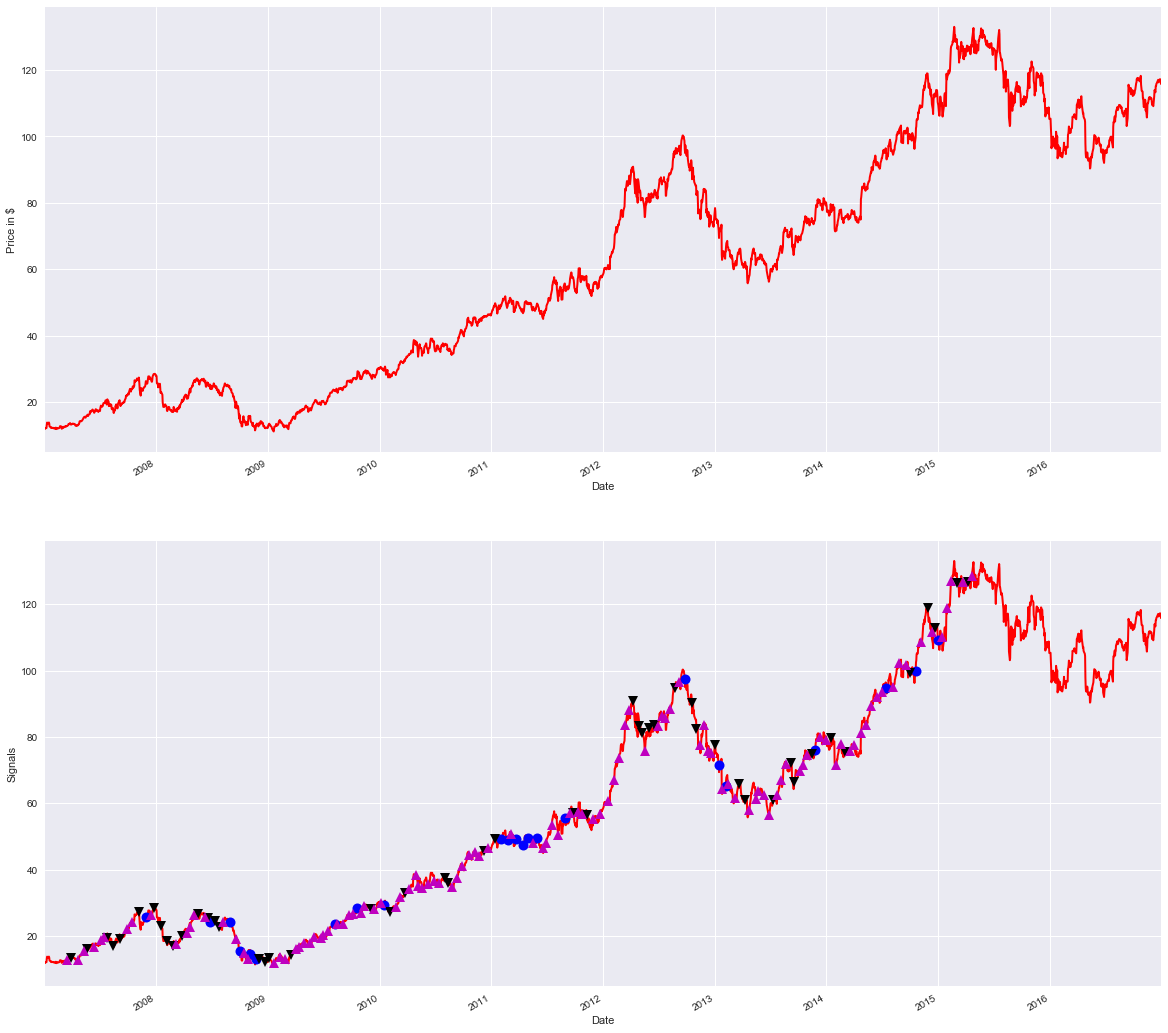

In [14]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211,  ylabel='Price in $')
ax2 = fig.add_subplot(212,  ylabel='Signals')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)
env.data['Close'].plot(ax=ax2, color='r', lw=2.)

ax2.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')

ax2.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax2.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=10, color='m')
       
# Show the plot
plt.show()

In [15]:
agent.save('best_model')